![PUC-Rio header](http://www.puc-rio.br/sobrepuc/admin/vrd/brasao/download/ass_horizpb_com4.jpg)

# Programming the WFG multi-objective problem toolkit in Python

## [César Revelo](https://github.com/CesarRevelo) and [Luis Martí](http://lmarti.com)
### Laboratory of Applied Intelligence and Robotics
### [Department of Electrical Engineering](http://www.ele.puc-rio.br)
### [Pontifícia Universidade Católica do Rio de Janeiro](http://www.puc-rio.br)

This notebook is meant to test and illustrate our implementation of the WFG problems.

Papers:

* Lucas Bradstreet, Luigi Barone, Lyndon While, Simon Huband, and Phil Hingston. Use of the WFG Toolkit and PISA for Comparison of Multi-objective Evolutionary Algorithms. 2007 IEEE Symposium on Computational Intelligence in Multi-criteria Decision-making. IEEE MCDM 2007, pages 382-389. IEEE, April 2007. [download](http://www.wfg.csse.uwa.edu.au/publications/WFG2007b.pdf)

* Simon Huband, Phil Hingston, Luigi Barone, and Lyndon While. A Review of Multi-objective Test Problems and a Scalable Test Problem Toolkit. IEEE Transactions on Evolutionary Computation, volume 10, no 5, pages 477-506. IEEE, October 2006. [download](http://www.wfg.csse.uwa.edu.au/publications/WFG2006c.pdf)

* Simon Huband, Luigi Barone, Lyndon While, and Phil Hingston. A Scalable Multi-objective Test Problem Toolkit. 3rd International Conference on Evolutionary Multi-Criterion Optimization. EMO 2005, volume 3410 of Lecture Notes in Computer Science, pages 280-294. Springer-Verlag, March 2005.

Existing implementations:

* Walking Fish Group WFG toolkit project: http://www.wfg.csse.uwa.edu.au/toolkit/
* jMetal: http://jmetal.sourceforge.net/problems.html

<br/>
<div class="alert alert-info">
    <p>
    <span class="label label-primary">To be merged inside DEAP!</span>
    After we test that the problem are correctly implemented we plan to submit the code to the [DEAP](http://github.com/deap/DEAP) guys.
    </p>
</div>
<div class="alert alert-warning">
    <p>
    <span class="label label-warning">Using DEAP</span>
    In tests we have used the develpment (master) version of DEAP.
    </p>
 </div>

In [1]:
from deap import algorithms, base, benchmarks, tools, creator, cma

In [2]:
import numpy as np
import pandas as pd
import array, random, os, matplotlib

In [3]:
import wfg

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# making our plots look good in a retina display
%config InlineBackend.figure_format = 'retina'

In [6]:
problem_creators = {'wfg1': wfg.create_instance_wfg1, 
                    'wfg2': wfg.create_instance_wfg2, 
                    'wfg3': wfg.create_instance_wfg3, 
                    'wfg4': wfg.create_instance_wfg4, 
                    'wfg5': wfg.create_instance_wfg5, 
                    'wfg6': wfg.create_instance_wfg6, 
                    'wfg7': wfg.create_instance_wfg7, 
                    'wfg8': wfg.create_instance_wfg8, 
                    'wfg9': wfg.create_instance_wfg9}

In [7]:
distance = 20                   # number of distance-related parameters(l) l==> {2, 4, 6,...} for WFG2 and WFG3
position = 4                    # number of position-related parameters(k) k==> {2(M-1), 3(M-1),...}
num_vars = distance + position  # number of problem variables

<a id='LOL'></a>

# Two-objective problems

In [8]:
num_objs = 2                  # number of objectives(M) k+l >= M

A function for creating a random point between a list of lower and upper bounds.

In [9]:
def uniform(low_list, up_list):
    return [random.uniform(l, h) for l, h in zip(low_list, up_list)]

## Test 1. Check that problem instances work

In [10]:
for problem_name in sorted(problem_creators):
    f, bounds = problem_creators[problem_name](distance, position, num_objs)
    ind = uniform(*bounds)
    print(problem_name, f(ind))

wfg1 [2.9534851988096023, 0.989607611672916]
wfg2 [0.89405486310052074, 3.3925363224015355]
wfg3 [1.4878044933190622, 2.7495202267579817]
wfg4 [0.90334081314213521, 4.3393154486257641]
wfg5 [1.9281559094409098, 3.2885766323553391]
wfg6 [2.0668566495053753, 3.4527505759533135]
wfg7 [2.2569715970453266, 2.2890916560761121]
wfg8 [1.4531221798596259, 4.2051673988422094]
wfg9 [2.169654772283354, 3.6625000451517113]


## Test 2. Run NSGA-II and MO-CMA-ES and check the results agains a known front 

Let's compare the non-dominated solutions produced by NSGA-II and MO-CMA-ES with the two-objective Pareto fronts downloadable from http://jmetal.sourceforge.net/problems.html.

In [11]:
creator.create("FitnessMin2D", base.Fitness, weights=(-1.,-1.))
creator.create("Individual2D", array.array, typecode='d',fitness=creator.FitnessMin2D)

### NSGA-II

We program the setup NSGA-II.

In [12]:
def nsga_ii(toolbox, indivual_class):
    toolbox.register("attr_float", uniform, 
                     toolbox.bounds_low, toolbox.bounds_high)
    toolbox.register("individual", tools.initIterate, indivual_class, toolbox.attr_float)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, 
                     low=toolbox.bounds_low, up=toolbox.bounds_high, eta=20.0)
    toolbox.register("mutate", tools.mutPolynomialBounded, 
                     low=toolbox.bounds_low, up=toolbox.bounds_high, eta=20.0, indpb=1.0/num_vars)
    toolbox.register("select", tools.selNSGA2)
    
    toolbox.pop_size = 100
    toolbox.max_gen = 1000
    toolbox.mut_prob = 0.1
    
    pop = toolbox.population(n=toolbox.pop_size)
    pop = toolbox.select(pop, len(pop))
    
    return algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=1-toolbox.mut_prob,
                                     mutpb=toolbox.mut_prob, stats=None,
                                     ngen=toolbox.max_gen,verbose=False)

In [13]:
def run_nsga_ii(problem_name, indivual_class):
    f, (bounds_low, bounds_high) = problem_creators[problem_name](distance, position, num_objs)
    toolbox = base.Toolbox()
    toolbox.register('evaluate', f)
    toolbox.bounds_low = bounds_low
    toolbox.bounds_high = bounds_high
    res,_ = nsga_ii(toolbox, indivual_class)
    
    return res, problem_name

Run NSGA-II for every problem. We are going to use the `multiprocessing` module to use all the available CPU cores and save some time.

In [14]:
def run_nsga_ii_on_2d_problem(problem_name):
    return run_nsga_ii(problem_name, creator.Individual2D)

In [15]:
%%time
from multiprocessing import Pool
nsga_ii_result_pairs = Pool().map(run_nsga_ii_on_2d_problem, problem_creators)

CPU times: user 54.5 ms, sys: 20.8 ms, total: 75.3 ms
Wall time: 2min 59s


In [16]:
nsga_ii_results = {name: data for data, name in nsga_ii_result_pairs}

### Multi-objective CMA-ES

We are our code is a modification [DEAP MO-CMA-ES example](https://github.com/DEAP/deap/blob/master/examples/es/cma_mo.py).

In [17]:
def euc_distance(feasible_ind, original_ind):
    """A distance function to the feasability region."""
    return sum((f - o)**2 for f, o in zip(feasible_ind, original_ind))

def closest_feasible(individual, lower_bound, upper_bound):
    """A function returning a valid individual from an invalid one."""
    feasible_ind = np.maximum(lower_bound, individual)
    feasible_ind = np.minimum(upper_bound, feasible_ind)
    return feasible_ind

def valid(individual, lower_bound, upper_bound):
    """Determines if the individual is valid or not."""
    if np.any(np.greater(lower_bound, individual)) or np.any(np.greater(individual, upper_bound)):
        return False
    return True

In [18]:
def mocmaes(toolbox, indivual_class):
    mu, lambda_ = 100, 100
    max_gen = 1000

    # The MO-CMA-ES algorithm takes a full population as argument
    population = [indivual_class(uniform(toolbox.bounds_low, toolbox.bounds_high)) 
                  for _ in range(mu)]

    for ind in population:
        ind.fitness.values = toolbox.evaluate(ind)

    strategy = cma.StrategyMultiObjective(population, sigma=1.0, mu=mu, lambda_=lambda_)
    
    toolbox.register("generate", strategy.generate, indivual_class)
    toolbox.register("update", strategy.update)
    
    for _ in range(max_gen):
        # Generate a new population
        population = toolbox.generate()

        # Evaluate the individuals
        fitnesses = toolbox.map(toolbox.evaluate, population)
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit
        
        # Update the strategy with the evaluated individuals
        toolbox.update(population)
    
    return strategy.parents

In [19]:
def run_mocmaes(problem_name, individual_class):
    f, (bounds_low, bounds_high) = problem_creators[problem_name](distance, position, num_objs)
    toolbox = base.Toolbox()
    
    toolbox.register('evaluate', f)
    toolbox.decorate("evaluate", tools.ClosestValidPenality(
            lambda ind: valid(ind, bounds_low, bounds_high), 
            lambda ind: closest_feasible(ind, bounds_low, bounds_high), 1.0e-6, euc_distance))
    
    toolbox.bounds_low = bounds_low
    toolbox.bounds_high = bounds_high
    res = mocmaes(toolbox, individual_class)
    
    return res, problem_name

In [20]:
def run_mocmaes_on_2d_problem(problem_name):
    return run_mocmaes(problem_name, creator.Individual2D)

In [21]:
%%time
mocmaes_result_pairs = Pool().map(run_mocmaes_on_2d_problem, problem_creators)

CPU times: user 288 ms, sys: 98.3 ms, total: 386 ms
Wall time: 9min 36s


In [22]:
mocmaes_results = {name: data for data, name in mocmaes_result_pairs}

In [23]:
non_dom = tools.sortLogNondominated(nsga_ii_results[problem_name],
                                        len(nsga_ii_results[problem_name]), 
                                        first_front_only=True)

### Loading jMetal pre-computed 2D Pareto fronts

In [92]:
jmetal_2d_pfs = {}
for i, problem_name in enumerate(sorted(problem_creators)):
    jmetal_2d_pfs[problem_name] = pd.read_table('WFG.2D' + os.sep + 'WFG' + str(i+1) + '.2D.pf',
                                                sep=' ', header=None).dropna(axis=1)

### Plotting the results

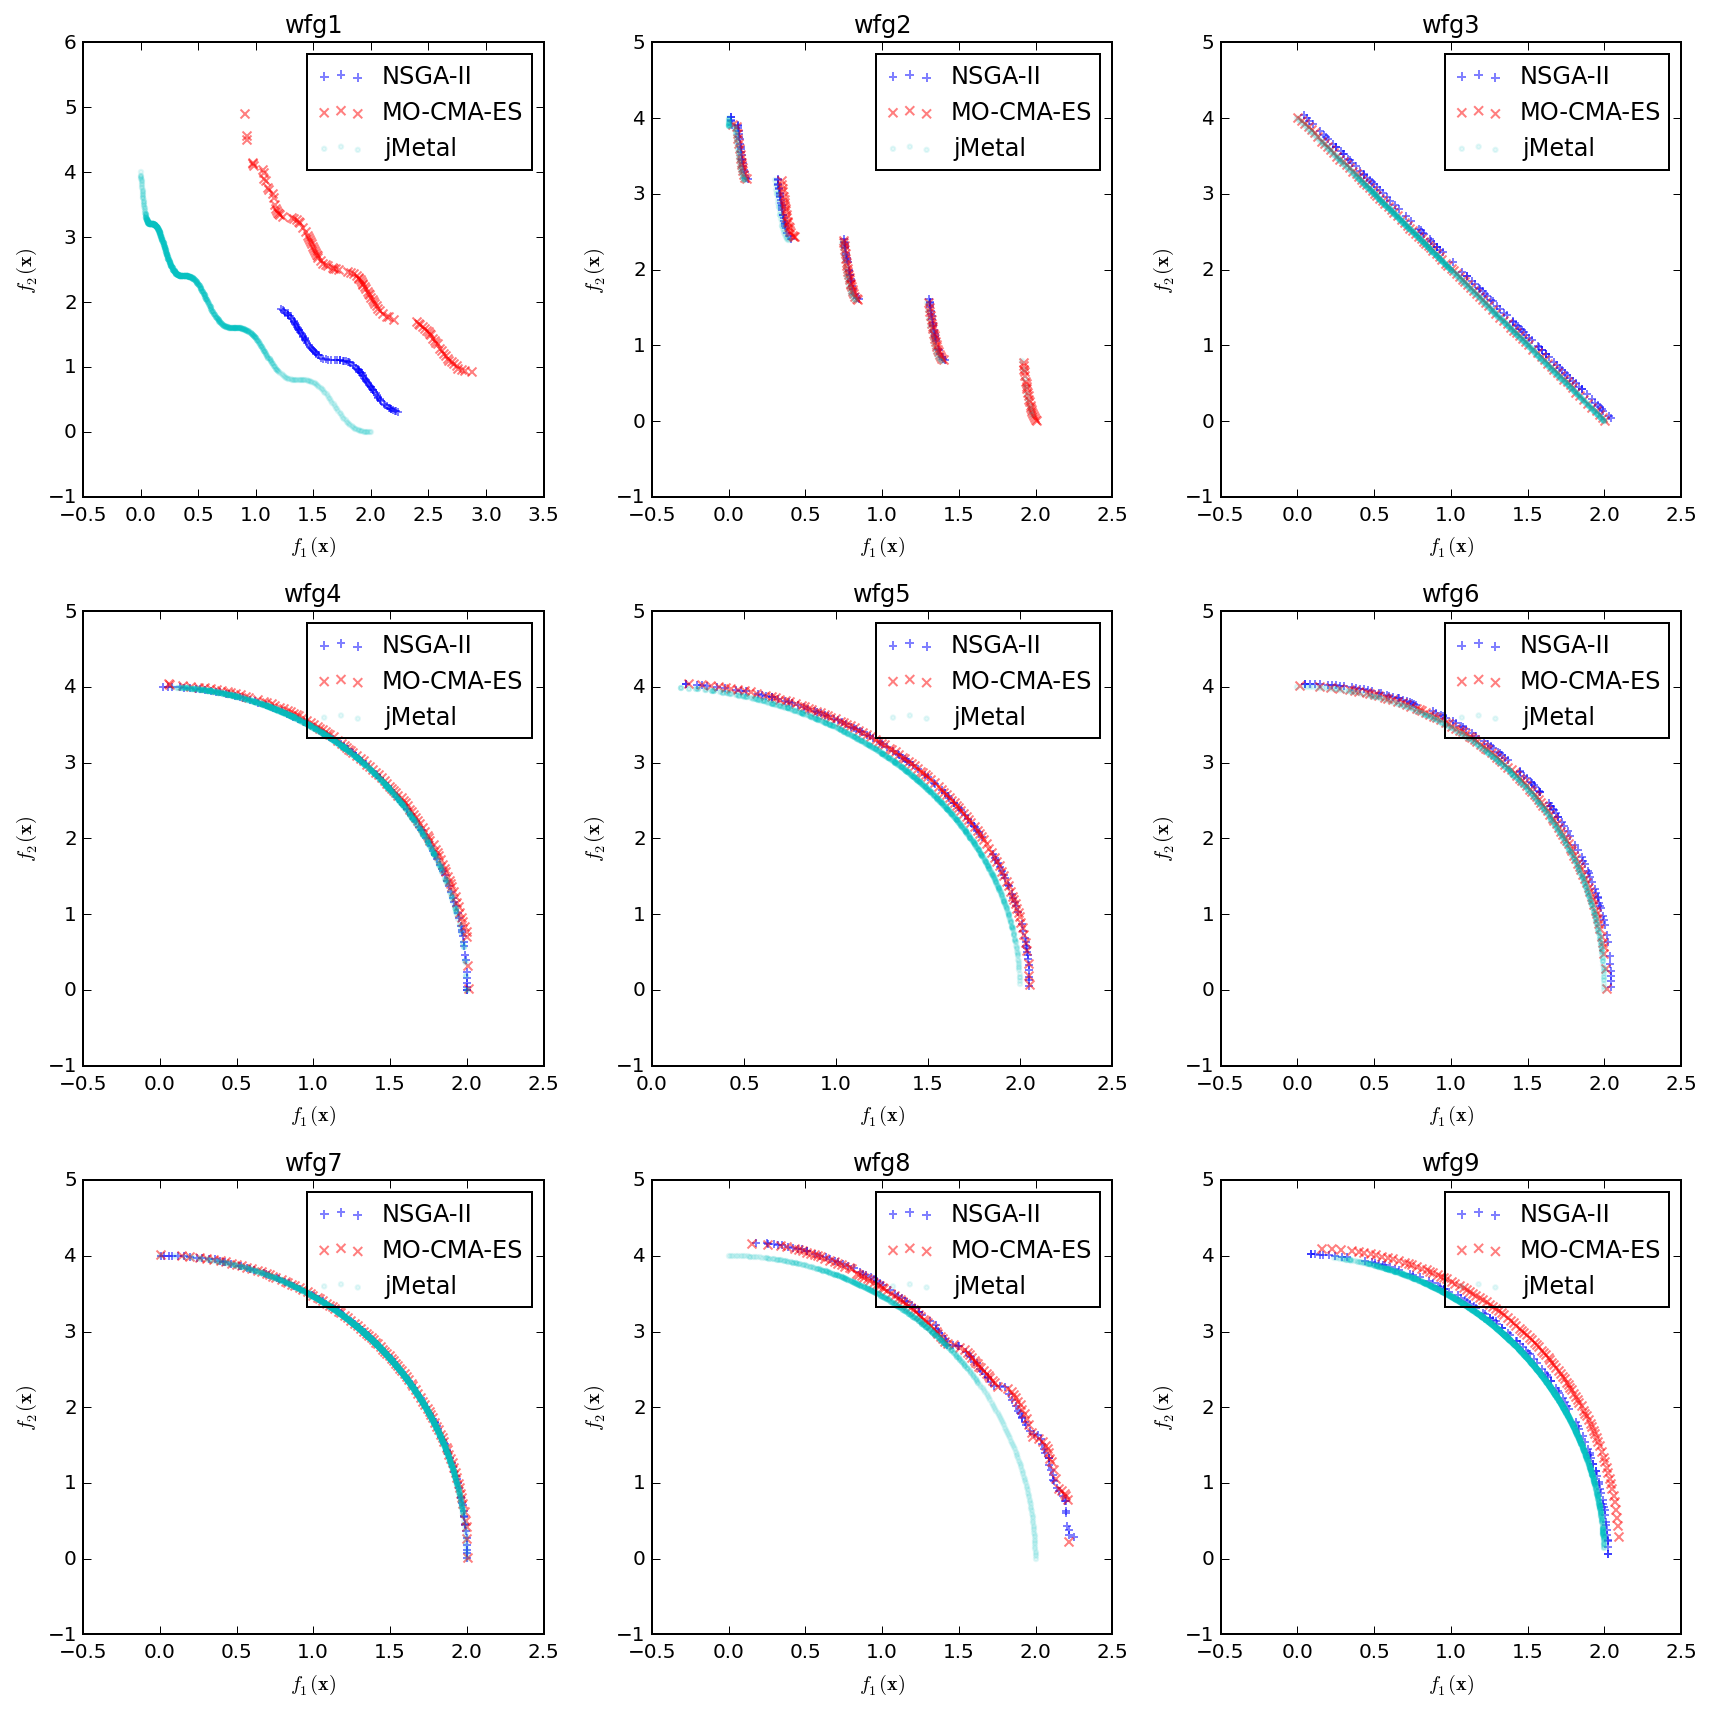

In [94]:
plt.figure(figsize=(4*(len(problem_creators)//3),4*3))
for i, problem_name in enumerate(sorted(problem_creators)):
    ax = plt.subplot(len(problem_creators)//3, 3, i+1)
    
    # NSGA-II
    non_dom = tools.sortLogNondominated(nsga_ii_results[problem_name],
                                        len(nsga_ii_results[problem_name]), 
                                        first_front_only=True)
    df = pd.DataFrame([ind.fitness.values for ind in non_dom])
    ax.scatter(df[df.columns[0]].values, df[df.columns[1]].values, label='NSGA-II', 
               marker='+', color='b', alpha=0.5)
    
    # MO-CMA-ES
    non_dom = tools.sortLogNondominated(mocmaes_results[problem_name],
                                        len(mocmaes_results[problem_name]),
                                        first_front_only=True)
    df = pd.DataFrame([ind.fitness.values for ind in non_dom])
    ax.scatter(df[df.columns[0]].values, df[df.columns[1]].values, label='MO-CMA-ES', 
               marker='x', color='r', alpha=0.5)
    
    # PF from jMetal guys
    jm = jmetal_2d_pfs[problem_name]
    ax.scatter(jm[jm.columns[0]].values, jm[jm.columns[1]].values, 
               marker='.', color='c', alpha=0.1, label='jMetal')
    
    plt.legend()
    plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$')
    plt.title(problem_name)
    
plt.tight_layout()

### Hypervolumes

In [26]:
def ref_point(problem_name):
    non_dom = tools.sortLogNondominated(nsga_ii_results[problem_name],
                                        len(nsga_ii_results[problem_name]), 
                                        first_front_only=True)
    ref = list(pd.DataFrame([ind.fitness.values for ind in non_dom]).max())

    non_dom = tools.sortLogNondominated(mocmaes_results[problem_name],
                                        len(mocmaes_results[problem_name]), 
                                        first_front_only=True)
    ref = np.maximum(ref, pd.DataFrame([ind.fitness.values for ind in non_dom]).max())

    jm = jmetal_2d_pfs[problem_name]

    ref = np.maximum(ref, list(jm.max()))
    return ref + 0.01

In [27]:
refs = [ref_point(problem_name) for problem_name in problem_creators]

In [37]:
ref = [0,0]

In [38]:
for item in refs:
    ref = np.maximum(ref, item)

In [39]:
ref

0    2.888905
1    4.913483
dtype: float64

In [40]:
try:
    # try importing the C version
    from deap.tools._hypervolume import hv
except ImportError:
    # fallback on python version
    from deap.tools._hypervolume import pyhv as hv

In [41]:
def hypervolume(front, ref):
    wobj = np.array([ind.fitness.values for ind in front])
    return hv.hypervolume(wobj, ref)

In [42]:
mocmaes_hypervols = {problem_name: hypervolume(mocmaes_results[problem_name], ref) 
                     for problem_name in mocmaes_results}

In [43]:
nsga_ii_hypervols = {problem_name: hypervolume(nsga_ii_results[problem_name], ref) 
                     for problem_name in nsga_ii_results}

In [44]:
jmetal_hypervols = {problem_name: hv.hypervolume(jmetal_2d_pfs[problem_name].values, ref) 
                    for problem_name in jmetal_2d_pfs}

In [45]:
s1 = pd.Series(jmetal_hypervols, index=sorted(jmetal_hypervols.keys()))
s2 = pd.Series(nsga_ii_hypervols, index=nsga_ii_hypervols.keys())
s3 = pd.Series(mocmaes_hypervols, index=mocmaes_hypervols.keys())

In [46]:
df = pd.DataFrame()

In [47]:
df['jMetal'] = s1
df['MO-CMA-ES'] = s2
df['NSGA-II'] = s3

In [48]:
df

,jMetal,MO-CMA-ES,NSGA-II
wfg1,11.287253,6.909075,5.018496
wfg2,10.578188,9.786981,10.523833
wfg3,10.174583,9.813818,10.103317
wfg4,7.825818,7.825357,7.700506
wfg5,7.686849,7.367204,7.350443
wfg6,7.890564,7.518385,7.778092
wfg7,7.907075,7.839766,7.829447
wfg8,7.895749,6.829112,6.902693
wfg9,7.563514,7.592125,6.945244


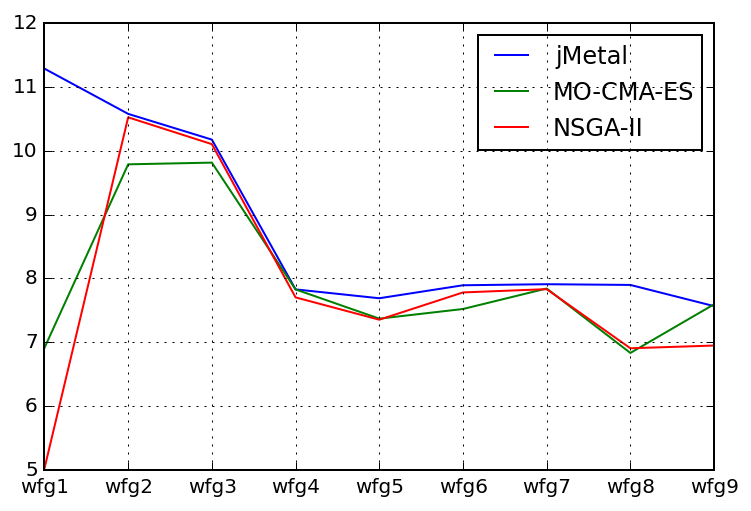

In [49]:
df.plot()

# Three-objective problems

In [50]:
num_objs = 3

In [51]:
for problem_name in sorted(problem_creators):
    f, bounds = problem_creators[problem_name](distance, position, num_objs)
    ind = uniform(*bounds)
    print(problem_name, f(ind))

wfg1 [2.955396713153764, 0.98471137053541036, 0.9846589390313909]
wfg2 [0.63706528376869886, 1.6203225926111218, 4.7705352128561627]
wfg3 [1.8977862309064693, 1.5829147138873347, 1.0392730628096383]
wfg4 [0.82994506064199114, 3.8791439089095658, 3.2617752677845178]
wfg5 [1.9413815627562019, 1.4269588842781709, 4.403399187388378]
wfg6 [2.3398821059624608, 0.82191907662197627, 3.9105081076015225]
wfg7 [1.1399639703809865, 3.0467660600604005, 4.6663544187769697]
wfg8 [1.069714283471189, 1.6761189465369293, 5.9511843792278976]
wfg9 [1.5013707688283637, 3.302316908862296, 3.8367531083848356]


In [52]:
creator.create("FitnessMin3D", base.Fitness, weights=(-1.,-1.,-1.))
creator.create("Individual3D", array.array, typecode='d',fitness=creator.FitnessMin3D)

Run NSGA-II and MO-CMA-ES for every problem, now with 3 objectives. Again, we are going to use all the CPU cores to save some time.

In [53]:
def run_mocmaes_on_3d_problem(problem_name):
    return run_mocmaes(problem_name, creator.Individual3D)

In [54]:
def run_nsga_ii_on_3d_problem(problem_name):
    return run_nsga_ii(problem_name, creator.Individual3D)

In [55]:
%%time
result_pairs = Pool().map(run_nsga_ii_on_3d_problem, problem_creators)

CPU times: user 139 ms, sys: 73.9 ms, total: 213 ms
Wall time: 3min 8s


In [56]:
nsga_ii_3d_results = {name: data for data, name in result_pairs}

In [57]:
%%time
result_pairs = Pool().map(run_mocmaes_on_3d_problem, problem_creators)

CPU times: user 1.76 s, sys: 712 ms, total: 2.47 s
Wall time: 35min 36s


In [58]:
mocmaes_3d_results = {name: data for data, name in result_pairs}

### Loading jMetal three-objective fronts

In [69]:
jmetal_3d_pfs = {}
for i, problem_name in enumerate(sorted(problem_creators)):
    jmetal_3d_pfs[problem_name] = pd.read_table('WFG.3D' + os.sep + 'WFG' + str(i+1) + '.3D.pf',
                                                sep=' ', header=None).dropna(axis=1)

### Ploting results

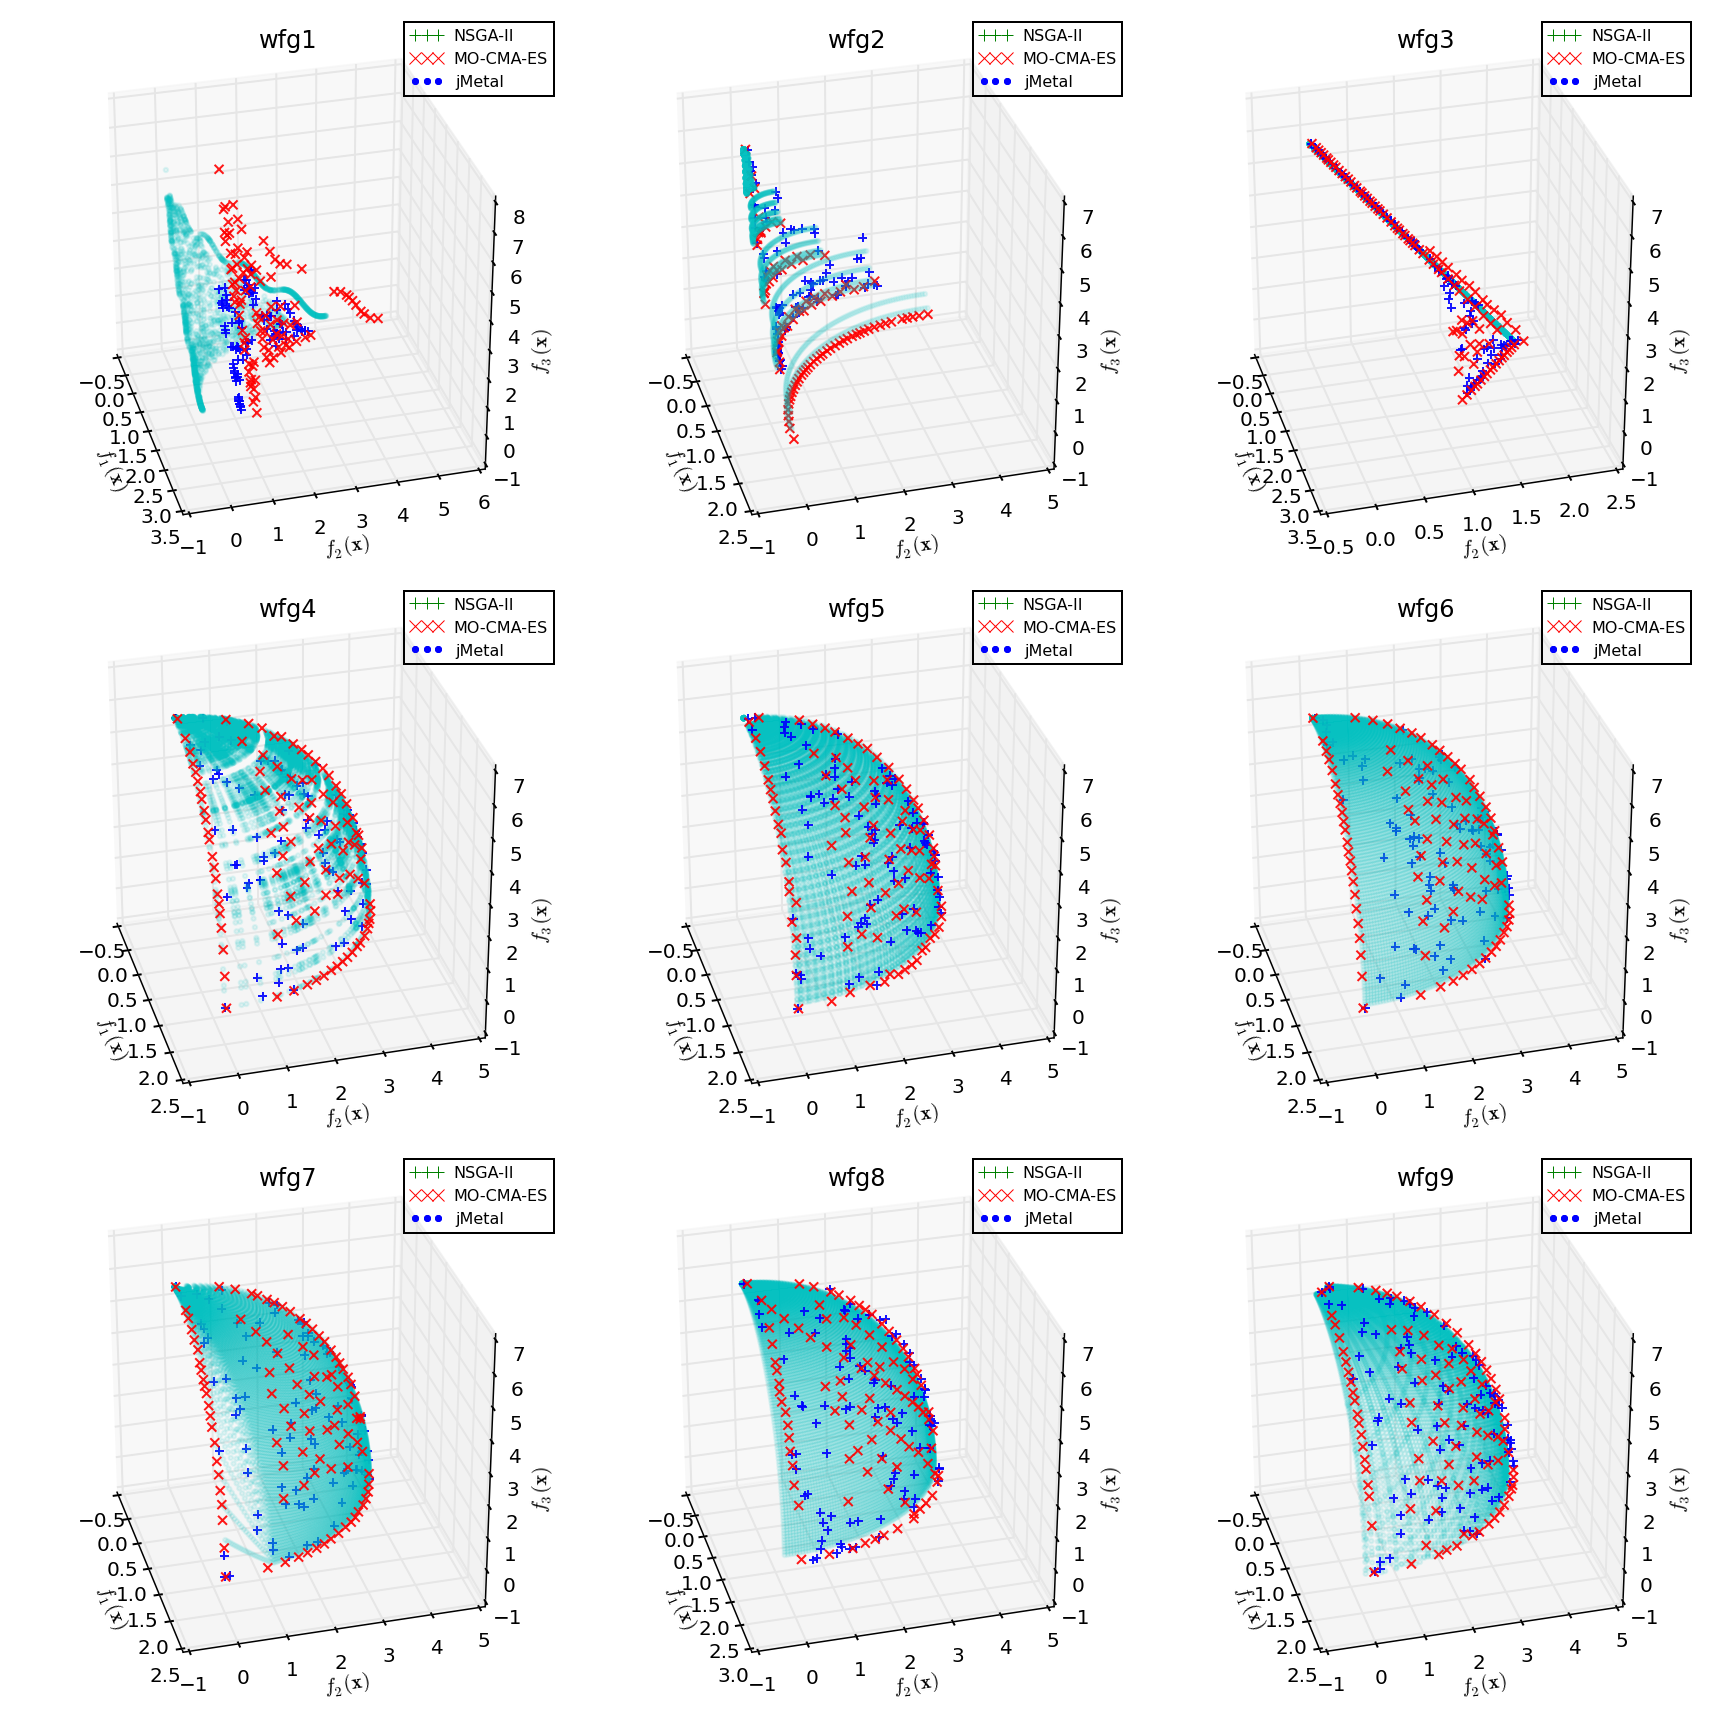

In [90]:
fig = plt.figure(figsize=(4*(len(problem_creators)//3),4*3))
for i, problem_name in enumerate(sorted(problem_creators)):
    ax = fig.add_subplot(len(problem_creators)//3,3,i+1, projection='3d')
    
    # NSGA-II
    non_dom = tools.sortLogNondominated(nsga_ii_3d_results[problem_name],
                                        len(nsga_ii_3d_results[problem_name]), 
                                        first_front_only=True)
    df = pd.DataFrame([ind.fitness.values for ind in non_dom]) 
    ax.scatter(df[df.columns[0]].values, df[df.columns[1]].values, df[df.columns[2]].values, 
               marker='+', color='b', alpha=0.9)
    
    # MO-CMA_ES
    non_dom = tools.sortLogNondominated(mocmaes_3d_results[problem_name],
                                        len(mocmaes_3d_results[problem_name]), 
                                        first_front_only=True)
    df = pd.DataFrame([ind.fitness.values for ind in non_dom]) 
    ax.scatter(df[df.columns[0]].values, df[df.columns[1]].values, df[df.columns[2]].values, 
               marker='x', color='r', alpha=0.9)
    
    jm = jmetal_3d_pfs[problem_name]
    ax.scatter(jm[jm.columns[0]].values, jm[jm.columns[1]].values,jm[jm.columns[2]].values, 
               marker='.', color='c', alpha=0.1)
    
    # a trick to show a legend in a 3d scatter plot.
    scatter1_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='g', marker = '+')
    scatter2_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='r', marker = 'x')
    scatter3_proxy = matplotlib.lines.Line2D([0],[0], linestyle="none", c='b', marker = '.')
    
    ax.legend([scatter1_proxy, scatter2_proxy,scatter3_proxy], 
              ['NSGA-II', 'MO-CMA-ES', 'jMetal'],
               numpoints = 3,fontsize=8)
    
    ax.set_xlabel('$f_1(\mathbf{x})$')
    ax.set_ylabel('$f_2(\mathbf{x})$')
    ax.set_zlabel('$f_3(\mathbf{x})$')
    
    ax.azim +=45 # better viewing angle
    plt.title(problem_name)
plt.tight_layout()

Another reference of how the fronts should look like:

<table>
<tr>
<td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg1b.jpg'/>
</td><td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg2b.jpg'/>
</td><td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg3b.jpg'/>
</td>
</tr>
<tr><td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg4b.jpg'/>
</td><td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg5b.jpg'/>
</td><td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg6b.jpg'/>
</tr>
<tr>
<td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg7b.jpg'/>
</td><td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg8b.jpg'/>
</td><td>
<img width='300' src='http://www.cs.cinvestav.mx/~emoobook/apendix-f/galeria5/wfg9b.jpg'/>
</td>
</tr>
</table>

Images are taken from Coello Coello, Lamont and Van Veldhuizen (2007) Evolutionary Algorithms for Solving Multi-Objective Problems, Second Edition. Springer [Appendix E](http://www.cs.cinvestav.mx/~emoobook/apendix-e/apendix-e.html).

### Hypervolumes

In [77]:
def ref_point_3d(problem_name):
    non_dom = tools.sortLogNondominated(nsga_ii_3d_results[problem_name],
                                        len(nsga_ii_3d_results[problem_name]), 
                                        first_front_only=True)
    ref = list(pd.DataFrame([ind.fitness.values for ind in non_dom]).max())

    non_dom = tools.sortLogNondominated(mocmaes_3d_results[problem_name],
                                        len(mocmaes_3d_results[problem_name]), 
                                        first_front_only=True)
    
    ref = np.maximum(ref, pd.DataFrame([ind.fitness.values for ind in non_dom]).max())

    jm = jmetal_3d_pfs[problem_name]
    
    ref = np.maximum(ref, list(jm.max()))
    return ref + 0.01

In [78]:
refs = [ref_point_3d(problem_name) for problem_name in problem_creators]

In [79]:
ref = [0,0,0]

In [80]:
for item in refs:
    ref = np.maximum(ref, item)

In [81]:
ref

0    3.010686
1    4.873658
2    6.932711
dtype: float64

In [82]:
mocmaes_3d_hypervols = {problem_name: hypervolume(mocmaes_3d_results[problem_name], ref) 
                        for problem_name in mocmaes_results}

In [83]:
nsga_ii_3d_hypervols = {problem_name: hypervolume(nsga_ii_3d_results[problem_name], ref) 
                        for problem_name in nsga_ii_results}

In [84]:
jmetal_3d_hypervols = {problem_name: hv.hypervolume(jmetal_3d_pfs[problem_name].values, ref) 
                    for problem_name in jmetal_3d_pfs}

In [85]:
s1 = pd.Series(jmetal_3d_hypervols, index=sorted(jmetal_hypervols.keys()))
s2 = pd.Series(nsga_ii_3d_hypervols, index=nsga_ii_hypervols.keys())
s3 = pd.Series(mocmaes_3d_hypervols, index=mocmaes_hypervols.keys())

In [86]:
df = pd.DataFrame()
df['jMetal'] = s1
df['MO-CMA-ES'] = s2
df['NSGA-II'] = s3

In [87]:
df

,jMetal,MO-CMA-ES,NSGA-II
wfg1,99.168251,54.658034,45.414287
wfg2,95.728281,79.563799,96.888518
wfg3,72.425620,72.090378,72.318186
wfg4,75.852547,71.222749,72.074368
wfg5,74.664106,67.134872,69.540683
wfg6,75.098318,68.696745,72.386792
wfg7,74.858529,72.091961,73.182407
wfg8,75.481488,63.471785,66.158785
wfg9,74.543652,63.044707,65.163361


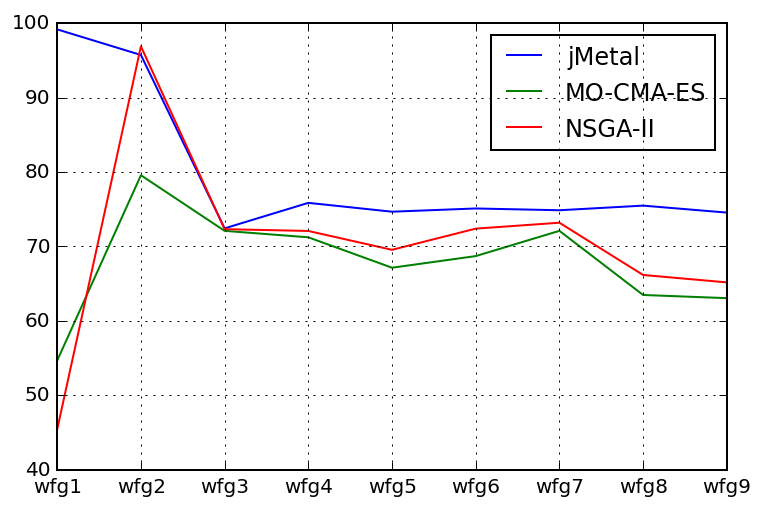

In [88]:
df.plot()